# 0. Import Required Packages

In [86]:
import math
import datetime
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn import decomposition, datasets
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedKFold

import warnings
warnings.filterwarnings("ignore")

# 1. Data Wrangling
## 1.1 Predictors

In [133]:
spy = pd.read_csv('./spy.csv', parse_dates=True, index_col=0)[1:]
data = pd.read_csv('./research_dataset_2022.csv', parse_dates=True, index_col=0)
data.dropna(subset=['trans_spy_open'], inplace=True)

data['DEF'] = data['BAA'] - data['AAA']
data['TERM'] = data['US10YR'] - data['US3M']
data['VRP'] = data['trans_VIX'] - data['garch']
#data['PCR'] = data['trans_spy_open'] / data['trans_SPGSCI']
data['PCR'] = np.log(spy['Open']) / data['trans_SPGSCI']
# the current price versus the past 10 month simple moving average.
#data['MA'] = data['trans_spy_open'] / data['trans_spy_open'].rolling(217).mean()
data['MA'] = np.log(spy['Open'] / spy['Open'].rolling(217).mean())

In [134]:
# CAY
X = data[['Consumption_new', 'Income_new']][1800:]; Y = data['Assets_new'][1800:]
LR = LinearRegression().fit(X, Y)
residual = Y - LR.predict(X)
data['CAY'] = [np.nan] * 1800 + residual.to_list()

In [135]:
# OBV
spy['OBV'] = np.nan
spy['OBV'].iloc[0] = spy.iloc[0]['Volume']
for i in range(1,len(spy)):
    if spy.iloc[i]['Close'] > spy.iloc[i-1]['Close']:
        spy['OBV'].iloc[i] = spy.iloc[i-1]['OBV'] + spy.iloc[i]['Volume']
    elif spy.iloc[i]['Close'] < spy.iloc[i-1]['Close']:
        spy['OBV'].iloc[i] = spy.iloc[i-1]['OBV'] - spy.iloc[i]['Volume']
    else:
        spy['OBV'].iloc[i] = spy.iloc[i-1]['OBV']
data['OBV'] = np.log(spy['OBV'])

In [152]:
# MOM
data['MOM'] = np.nan
for i in range(len(spy)):
    data['MOM'] = np.log(spy['Open'] / spy['Open'].shift(-12))

In [153]:
var = data[['DividendToPriceRatio', 'trans_PE_RATIO', 'PxToBook', 'CAPE',
            'bbyield', 'DEF', 'TERM', 'CAY', 'SIM', 'VRP', 'IC', 'trans_BDIY',
            'NOS', 'CPI', 'PCR', 'MA', 'OBV', 'MOM', 'SI', 'BER', 'NAPMPRIC', 
            'CATY', 'IND_PROD']]
var.rename(columns = {'DividendToPriceRatio':'DP', 'trans_PE_RATIO':'PE',
                      'PxToBook':'BM', 'bbyield':'BY', 'trans_BDIY':'BDI',
                      'NAPMPRIC':'PRIC', 'IND_PROD':'IP'}, inplace = True)
# Replace NaN Values with Zeros
var = var.fillna(0)

## 1.2 Principle Component

In [154]:
std_slc = StandardScaler()
pca = decomposition.PCA(n_components=1)

# PCA_Price
X_price = var.loc[:, ['DP','PE','BM','CAPE']]
X_price_std = std_slc.fit_transform(X_price)
PCA_price = pca.fit_transform(X_price_std)
var.insert(loc=4, column='PCA_Price', value=PCA_price)

# PCA Tech
X_tech = var.loc[:, ['MA','OBV','MOM']]
X_tech_std = std_slc.fit_transform(X_tech)
PCA_tech = pca.fit_transform(X_tech_std)
var.insert(loc=19, column='PCA_Tech', value=PCA_tech)

var = var.drop(['DP','PE','BM','CAPE', 'MA','OBV','MOM'], axis=1)

## 1.3 Correlation between Predictors

<AxesSubplot:>

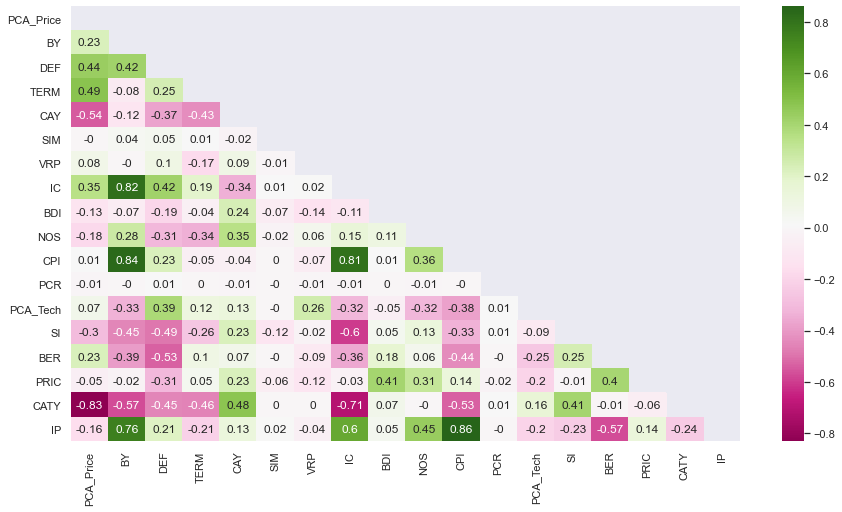

In [155]:
sn.set(rc = {'figure.figsize':(15,8)})
sn.heatmap(np.round(var.corr(), 2), mask=np.triu(np.ones_like(var.corr(), dtype=np.bool)), 
           cmap="PiYG", annot=True)

## 1.4 PCA to Aviod Multicollinearity

In [156]:
# PCA_Econ
X_econ = var.loc[:, ['BY','IC','CPI','IP']]
X_econ_std = std_slc.fit_transform(X_econ)
PCA_econ = pca.fit_transform(X_econ_std)
var.insert(loc=18, column='PCA_Econ', value=PCA_econ)

# new PCA_Price
var['DP'] = data['DividendToPriceRatio']; var['PE'] = data['trans_PE_RATIO']
var['BM'] = data['PxToBook']; var['CAPE'] = data['CAPE']
X_price_new = var.loc[:, ['DP','PE','BM','CAPE', 'CATY']]
X_price_new_std = std_slc.fit_transform(X_price_new)
PCA_price_new = pca.fit_transform(X_price_new_std)
var.insert(loc=1, column='PCA_Price_New', value=PCA_price_new)

var = var.drop(['BY','IC','CPI','IP', 'DP','PE','BM','CAPE', 'CATY', 'PCA_Price'], axis=1)

<AxesSubplot:>

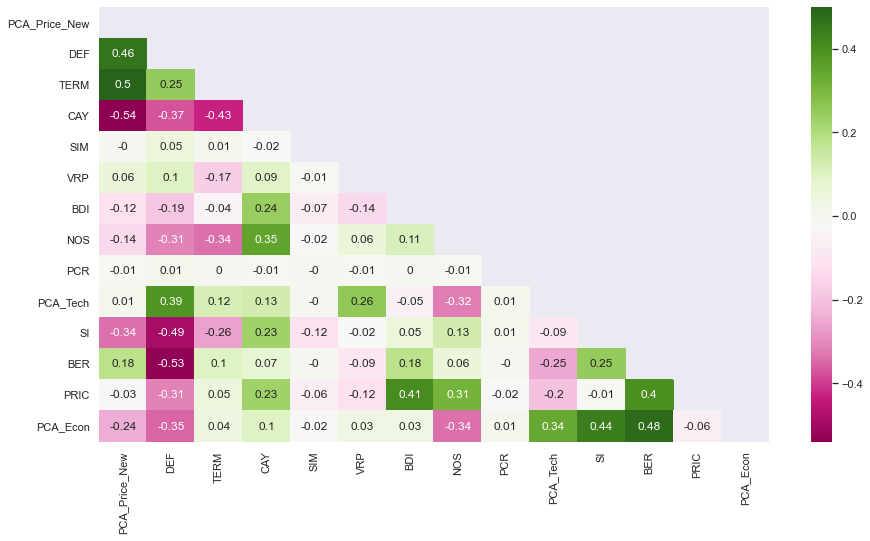

In [157]:
sn.set(rc = {'figure.figsize':(15,8)})
sn.heatmap(np.round(var.corr(), 2), mask=np.triu(np.ones_like(var.corr(), dtype=np.bool)), 
           cmap="PiYG", annot=True)

## 1.5 Future Returns

In [158]:
var['oneMReturn'] = (-spy['Open'].pct_change(-22)).to_numpy()
var['threeMReturn'] = (-spy['Open'].pct_change(-65)).to_numpy()
var['sixMReturn'] = (-spy['Open'].pct_change(-130)).to_numpy()
var['oneYReturn'] = (-spy['Open'].pct_change(-260)).to_numpy()

## 1.6 Correlation between Predictors and Future Returns

In [159]:
oneM = round(var[var.columns].corr()['oneMReturn'][:14], 3)
threeM = round(var[var.columns].corr()['threeMReturn'][:14], 3)
sixM = round(var[var.columns].corr()['sixMReturn'][:14], 3)
oneY = round(var[var.columns].corr()['oneYReturn'][:14], 3)
pd.DataFrame({'1MReturn': oneM, '3MReturn': threeM, '6MReturn': sixM, '1YReturn': oneY})

,1MReturn,3MReturn,6MReturn,1YReturn
PCA_Price_New,0.054,0.080,0.119,0.231
DEF,-0.059,-0.096,-0.063,0.014
TERM,-0.051,-0.096,-0.087,0.032
CAY,-0.064,-0.137,-0.233,-0.403
SIM,0.070,0.054,0.016,-0.006
VRP,0.016,0.086,0.091,0.026
BDI,0.099,0.084,-0.016,-0.159
NOS,-0.042,-0.114,-0.135,-0.181
PCR,-0.005,-0.013,-0.012,-0.015
PCA_Tech,-0.091,-0.168,-0.199,-0.244
